## Image Captioning

![Image Captioning](../assets/image_captioning.png)

**ViT-GPT2**: It is a PyTorch model for generating image captions, built by combining Vision Transformer (ViT) for visual feature extraction and GPT-2 for text generation. Trained on the COCO dataset, it leverages ViT’s ability to encode rich image details and GPT-2’s fluency in language production to create accurate and descriptive captions. This open-source model offers an effective solution for image understanding and captioning tasks.

Device set to use mps:0


[{'generated_text': 'a soccer game with a player jumping to catch the ball '}]

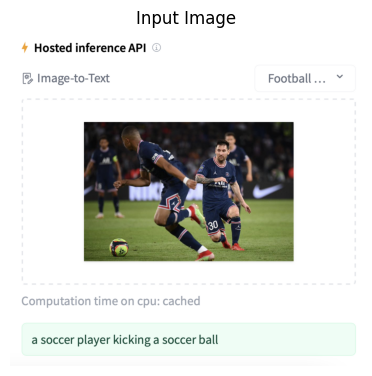

In [2]:
from transformers import pipeline
import requests
from PIL import Image
import matplotlib.pyplot as plt

image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

url = "https://ankur3107.github.io/assets/images/image-captioning-example.png"
image = Image.open(requests.get(url, stream=True).raw)

# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Input Image")
plt.axis('off')


image_to_text(image)

**BLIP-Image-Captionin**: It is a state-of-the-art image captioning model based on BLIP, a framework pre-trained on both clean and noisy web data for unified vision-language understanding and generation. It utilizes a bootstrapping process to filter out noisy captions, achieving improved performance on tasks like image captioning, image-text retrieval, and VQA. This large version, built with a ViT-L backbone, excels in generating accurate and detailed captions from images. 

a photography of a woman and her dog on the beach
woman sitting on the beach with her dog and a cell phone


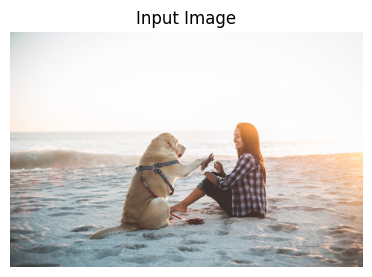

In [4]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import matplotlib.pyplot as plt

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-large"
)

img_url = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(raw_image)
plt.title("Input Image")
plt.axis('off')

# conditional image captioning
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

**git-base:** microsoft/git-base is a base-sized version of the GIT (GenerativeImage2Text) model, a Transformer decoder trained to generate text descriptions of images. It takes both image tokens and text tokens as input, predicting the next text token based on both the image and previous text. This makes it suitable for tasks like image and video captioning. Fine-tuned versions like microsoft/git-base-coco and microsoft/git-base-textcaps exist for specific datasets, while the base model offers a starting point for further customization.

two cats sleeping on a pink blanket next to remotes.


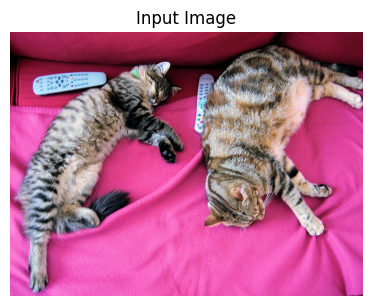

In [5]:
from transformers import AutoProcessor, AutoModelForCausalLM
import requests
from PIL import Image
import matplotlib.pyplot as plt


processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Input Image")
plt.axis('off')

pixel_values = processor(images=image, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)


## Image Text Retrieval

**CLIP (Contrastive Language-Image Pretraining)**: It excels in image-text retrieval by leveraging a shared embedding space. Through contrastive learning, it pretrains on large-scale image and text datasets, enabling the model to map diverse concepts into a common space. CLIP leverages a contrastive learning approach during pretraining, where it learns to map images and text into a shared embedding space. This shared space enables direct comparison between the two modalities, allowing for efficient and accurate retrieval tasks. In image-text retrieval, CLIP can be applied by encoding images and text into the shared embedding space, and the similarity between an image and a textual query is measured by the proximity of their respective embeddings. The model’s versatility arises from its ability to grasp semantic relationships without task-specific fine-tuning, making it efficient for applications ranging from content-based image retrieval to interpreting natural language queries for images.


a photo of a cat: 99.49%
a photo of a dog: 0.51%


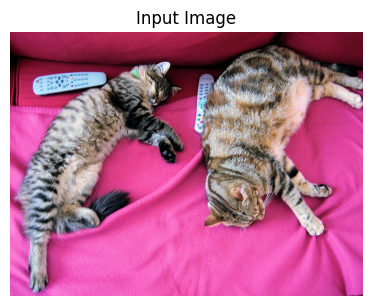

In [9]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Input Image")
plt.axis('off')

inputs = processor(
    text=["a photo of a cat", "a photo of a dog"],
    images=image,
    return_tensors="pt",
    padding=True,
)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(
    dim=1
).detach().numpy()[0]  # we can take the softmax to get the label probabilities
for prob, label in zip(probs, ["a photo of a cat", "a photo of a dog"]):
    print(f"{label}: {prob.item():.2%}")


## Visual Grounding

**OWL-ViT:** OWL-ViT (Vision Transformer for Open-World Localization) is a powerful object detection model built on a standard Vision Transformer architecture and trained on large-scale image-text pairs. It excels at “open-vocabulary” detection, meaning it can identify objects not present in its training data based on textual descriptions. By leveraging contrastive pre-training and fine-tuning, OWL-ViT achieves impressive performance in both zero-shot (text-guided) and one-shot (image-guided) detection tasks, making it a versatile tool for flexible search and identification in images.

Detection results:
Detected a photo of a cat with confidence 0.707 at location [324.97, 20.44, 640.58, 373.29]
Detected a photo of a cat with confidence 0.717 at location [1.46, 55.26, 315.55, 472.17]


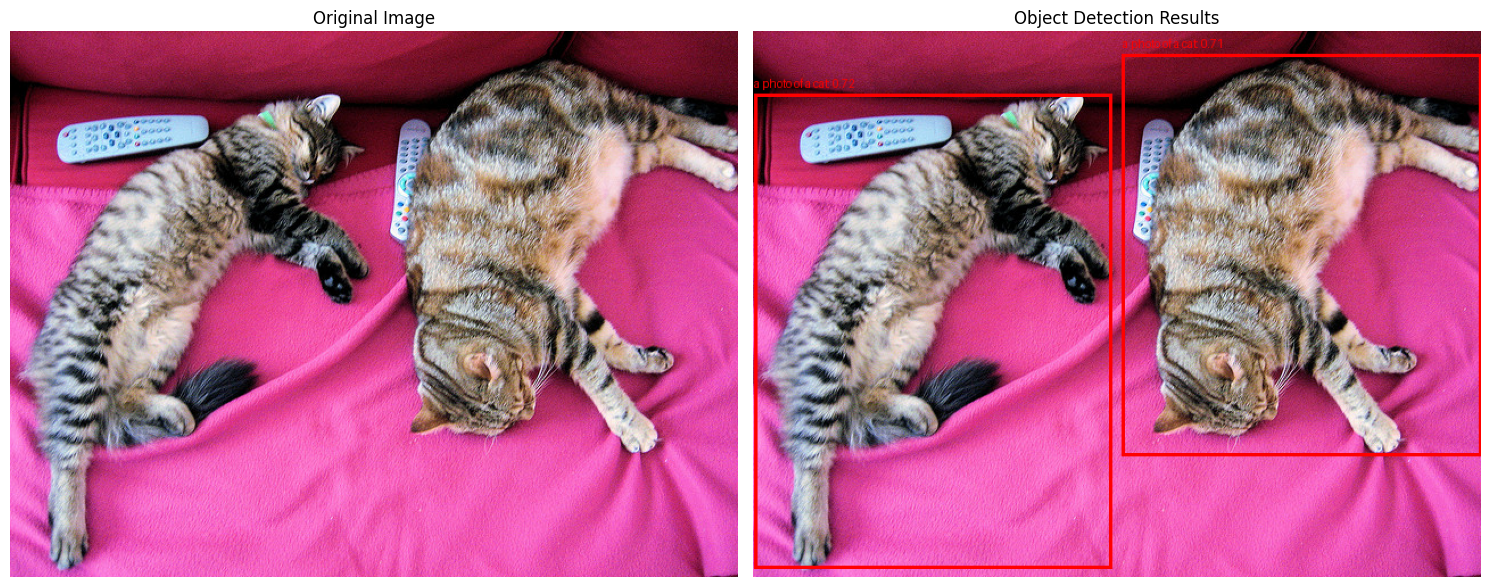

In [13]:
import requests
from PIL import Image, ImageDraw, ImageFont
import torch
import matplotlib.pyplot as plt
import numpy as np

from transformers import OwlViTProcessor, OwlViTForObjectDetection

# Load model and processor
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

# Load image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Define text queries
texts = [["a photo of a cat", "a photo of a dog"]]

# Process inputs
inputs = processor(text=texts, images=image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])

# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process_object_detection(
    outputs=outputs, threshold=0.1, target_sizes=target_sizes
)

# Create a copy of the image to draw on
image_with_boxes = image.copy()
draw = ImageDraw.Draw(image_with_boxes)

# Define colors for different classes
colors = {
    "a photo of a cat": (255, 0, 0),  # Red for cats
    "a photo of a dog": (0, 0, 255)   # Blue for dogs
}

i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Print and draw detected objects
print("Detection results:")
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    class_name = text[label]
    color = colors[class_name]
    
    # Print detection
    print(f"Detected {class_name} with confidence {round(score.item(), 3)} at location {box}")
    
    # Draw bounding box
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline=color, width=3)
    
    # Add label with confidence score
    label_text = f"{class_name}: {round(score.item(), 2)}"
    draw.text((box[0], box[1] - 15), label_text, fill=color)

# Display the original and annotated images side by side
plt.figure(figsize=(15, 7))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Image with detections
plt.subplot(1, 2, 2)
plt.imshow(image_with_boxes)
plt.title("Object Detection Results")
plt.axis("off")

plt.tight_layout()
plt.show()


New detection results:
Detected a photo of a remote control with confidence 0.231 at location [40.03, 72.43, 177.76, 115.58]
Detected a photo of a remote control with confidence 0.224 at location [335.71, 74.17, 371.88, 187.55]
Detected a photo of a tabby cat with confidence 0.662 at location [324.97, 20.44, 640.58, 373.29]
Detected a photo of a tabby cat with confidence 0.639 at location [1.46, 55.26, 315.55, 472.17]
Detected a photo of a couch with confidence 0.152 at location [4.11, 0.68, 643.0, 477.0]


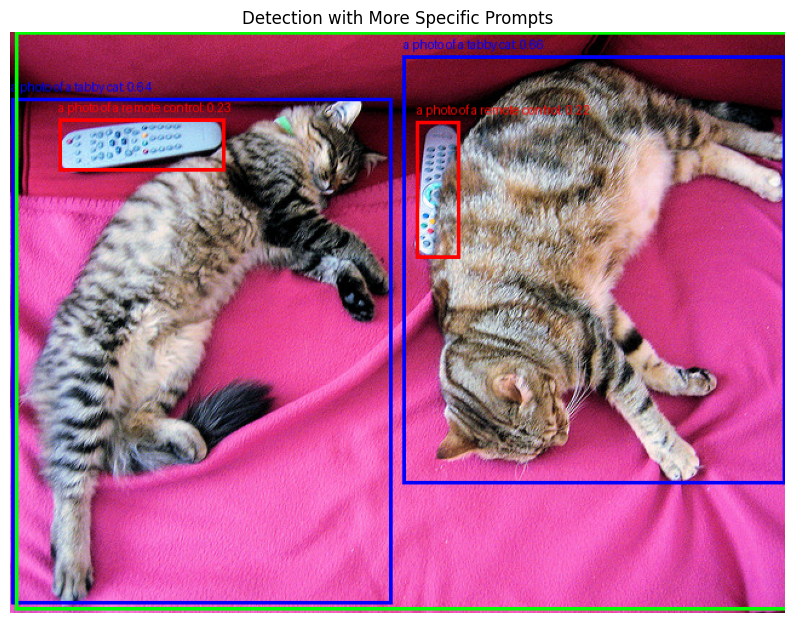

In [14]:
# Try with different text prompts
new_texts = [["a photo of a remote control", "a photo of a couch", "a photo of a tabby cat"]]

# Process inputs with new text prompts
new_inputs = processor(text=new_texts, images=image, return_tensors="pt")
new_outputs = model(**new_inputs)

# Convert outputs to COCO API
new_results = processor.post_process_object_detection(
    outputs=new_outputs, threshold=0.1, target_sizes=target_sizes
)

# Create another copy of the image
image_with_new_boxes = image.copy()
draw_new = ImageDraw.Draw(image_with_new_boxes)

# Define colors for different classes
new_colors = {
    "a photo of a remote control": (255, 0, 0),    # Red
    "a photo of a couch": (0, 255, 0),             # Green
    "a photo of a tabby cat": (0, 0, 255)          # Blue
}

# Get results for the first image
new_text = new_texts[0]
new_boxes, new_scores, new_labels = new_results[0]["boxes"], new_results[0]["scores"], new_results[0]["labels"]

# Print and draw new detected objects
print("\nNew detection results:")
for box, score, label in zip(new_boxes, new_scores, new_labels):
    box = [round(i, 2) for i in box.tolist()]
    class_name = new_text[label]
    color = new_colors[class_name]
    
    # Print detection
    print(f"Detected {class_name} with confidence {round(score.item(), 3)} at location {box}")
    
    # Draw bounding box
    draw_new.rectangle([(box[0], box[1]), (box[2], box[3])], outline=color, width=3)
    
    # Add label with confidence score
    label_text = f"{class_name}: {round(score.item(), 2)}"
    draw_new.text((box[0], box[1] - 15), label_text, fill=color)

# Display the results with new text prompts
plt.figure(figsize=(10, 10))
plt.imshow(image_with_new_boxes)
plt.title("Detection with More Specific Prompts")
plt.axis("off")
plt.show()

**Grounding DINO[3]:** It combines the Transformer-based object detector (DINO) with “grounded pre-training” to create a state-of-the-art, zero-shot object detection model. This means it can identify objects even if they weren’t in its training data, thanks to its ability to understand both images and human language inputs (like category names or descriptions). Its architecture combines text and image backbones, a feature enhancer, language-guided query selection, and a cross-modality decoder, achieving impressive results on benchmarks like COCO and LVIS. Essentially, Grounding DINO takes visual information, links it to textual descriptions, and then uses that understanding to pinpoint objects even within completely new categories

https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-with-grounding-dino.ipynb 